In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!rm -r dataset
!unzip /content/drive/MyDrive/miniProject/benetech-making-graphs-accessible.zip -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/train/images/eaed09039206.jpg  
  inflating: dataset/train/images/eaed1e245167.jpg  
  inflating: dataset/train/images/eaedb251e670.jpg  
  inflating: dataset/train/images/eaeead418936.jpg  
  inflating: dataset/train/images/eaeeb1c2ecdd.jpg  
  inflating: dataset/train/images/eaef70ba842d.jpg  
  inflating: dataset/train/images/eaf036991cb3.jpg  
  inflating: dataset/train/images/eaf06e9e07db.jpg  
  inflating: dataset/train/images/eaf20f7d8945.jpg  
  inflating: dataset/train/images/eaf3a9a87868.jpg  
  inflating: dataset/train/images/eaf3d05d20a6.jpg  
  inflating: dataset/train/images/eaf3d24fb032.jpg  
  inflating: dataset/train/images/eaf3f734b5ce.jpg  
  inflating: dataset/train/images/eaf467f871a2.jpg  
  inflating: dataset/train/images/eaf65b4e3c45.jpg  
  inflating: dataset/train/images/eaf7f876411a.jpg  
  inflating: dataset/train/images/eafa35356cf8.jpg  
  inflating: dataset/train/images/eafa65caf8e7.j

In [3]:
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git

Cloning into 'vision'...
remote: Enumerating objects: 337138, done.
remote: Counting objects: 100% (53370/53370), done.
remote: Compressing objects: 100% (1267/1267), done.
remote: Total 337138 (delta 52683), reused 52644 (delta 52075), pack-reused 283768
Receiving objects: 100% (337138/337138), 676.32 MiB | 34.36 MiB/s, done.
Resolving deltas: 100% (310534/310534), done.


In [4]:
!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

In [5]:
import cv2
import json
import matplotlib.pyplot as plt
import pandas as pd
import random
import shutil
from glob import glob
from tqdm import tqdm
import os
import random
import numpy as np
import pandas as pd
import cv2
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from engine import train_one_epoch, evaluate
import utils
import transforms as T
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.patches as patches

random.seed(108)

**Customdataset**

In [6]:
WIDTH = 480
HEIGHT = 480

In [7]:
def extract_plot_bb(data,image = "None"):
    w = data["plot-bb"]["width"]
    h = data["plot-bb"]["height"]
    x0 = data["plot-bb"]["x0"]
    y0 = data["plot-bb"]["y0"]
    x1 = data["plot-bb"]["y0"] + w
    y1 = data["plot-bb"]["y0"] + h
    image_w,image_h,c = image.shape
    x0 = max((x0/image_h) * WIDTH,0)
    y0 = max((y0/image_w) * HEIGHT,0)
    x1 = max(min((x1/image_h) * WIDTH,WIDTH),x0 + 0.01)
    y1 = max(min((y1/image_w) * HEIGHT,HEIGHT),y0+ 0.01)
    area = (y1 - y0) * (x1 - x0)
    return [x0, y0, x1, y1,area, "plot-bb"]



def extract_label_bbox(data, rows, img_id,image = "None"):
    common = []
    if data["chart-type"] != 'scatter':
      return None
    if img_id == '3ef41bbc82c3':
      return None
    common+= [img_id, data["source"], data["chart-type"]]
    # TRAIN_FOLDER = "/content/dataset/train/images/"
    # image = cv2.imread(TRAIN_FOLDER + img_id + ".jpg")
    image_w,image_h,c = image.shape
    # print(image_w,image_h)
    for box in data["text"]:
        # x0 = box["polygon"]["x0"]
        # y0 = box["polygon"]["y1"]
        # w = abs(box["polygon"]["x1"] - box["polygon"]["x0"]) + abs(box["polygon"]["x2"] - box["polygon"]["x1"])
        # h = abs(box["polygon"]["y3"] - box["polygon"]["y1"])
        # x0 = box["polygon"]["x0"]
        # y0 = box["polygon"]["y0"]
        # w = box["polygon"]["x1"] - box["polygon"]["x0"]
        # h = box["polygon"]["y3"] - box["polygon"]["y0"]
        # print(box["polygon"]["x2"],box["polygon"]["x0"],box["polygon"]["y2"],box["polygon"]["y0"])
        x0 = box["polygon"]["x0"] 
        y0 = box["polygon"]["y0"]
        x1 = box["polygon"]["x2"] 
        y1 = box["polygon"]["y2"]

        x0 = max((x0/image_h) * WIDTH,0)
        y0 = max((y0/image_w) * HEIGHT,0)
        x1 = max(min((x1/image_h) * WIDTH,WIDTH),x0+0.01)
        y1 = max(min((y1/image_w) * HEIGHT,HEIGHT),y0+0.01)
        area = (y1 - y0) * (x1 - x0)
        label = box["role"]
        # print(label)
        box_row = common + [x0, y0, x1, y1,area, label]
        rows.append(box_row)
    rows.append(common + extract_plot_bb(data,image)) 
    return rows
        
def extract_tick_bbox(data, rows, img_id,image = "None"):
    common = []
    common+= [img_id , data["source"], data["chart-type"]]
    # TRAIN_FOLDER = "/content/dataset/train/images/"
    # image = cv2.imread(TRAIN_FOLDER + img_id + ".jpg")
    image_w,image_h,c = image.shape
    for axis in data["axes"].keys():
        for box in data["axes"][axis]["ticks"]:
            x0 = box["tick_pt"]["x"] - 2.5
            y0 = box["tick_pt"]["y"] - 2.5
            x1 = box["tick_pt"]["x"] + 2.5
            y1 = box["tick_pt"]["y"] + 2.5

            x0 = max((x0/image_h) * WIDTH,0)
            y0 = max((y0/image_w) * HEIGHT,0)
            x1 = max(min((x1/image_h) * WIDTH,WIDTH),x0+0.01)
            y1 = max(min((y1/image_w) * HEIGHT,HEIGHT),y0+0.01)

            label = axis + "-tick"
            area = (y1 - y0) * (x1 - x0)
            box_row = common + [x0, y0, x1, y1,area,label]
            rows.append(box_row)

    for axis in data["visual-elements"]["scatter points"]:
        for box in axis:

            x0 = box["x"] - 5
            y0 = box["y"] - 5
            x1 = box["x"] + 5
            y1 = box["y"] + 5

            x0 = max((x0/image_h) * WIDTH,0)
            y0 = max((y0/image_w) * HEIGHT,0)
            x1 = max(min((x1/image_h) * WIDTH,WIDTH),x0+0.01)
            y1 = max(min((y1/image_w) * HEIGHT,HEIGHT),y0+0.01)
            area = (y1 - y0) * (x1 - x0)
            label = "visual-point"
            box_row = common + [x0, y0, x1, y1,area,label]
            rows.append(box_row)

    return rows

In [8]:
ANNOTATION = "/content/dataset/train/annotations/*.json"
TRAIN_FOLDER = "/content/dataset/train/images/"
rows = []
for file_name in tqdm(glob(ANNOTATION)):
    label_bbox = []
    tick_bbox = []
    with open(file_name) as f:
        data = json.load(f)
        img_id = file_name.split("/")[-1].split(".")[0]
        image = cv2.imread(TRAIN_FOLDER + img_id + ".jpg")
        label_bbox = extract_label_bbox(data, label_bbox, img_id,image)
        if label_bbox == None:
           continue
        tick_bbox = extract_tick_bbox(data, tick_bbox, img_id,image)
        # print(label_bbox)
        # print(tick_bbox)
        data_rows = label_bbox + tick_bbox
    rows += data_rows
    # break

100%|██████████| 60578/60578 [02:14<00:00, 451.83it/s]


In [9]:
df = pd.DataFrame(rows)
df.columns = ["image_id", "source", "chart", "x0", "y0", "x1", "y1", "area","label"]
df.head()

,image_id,source,chart,x0,y0,x1,y1,area,label
0,a16e20985f9f,generated,scatter,66.952790,8.791209,414.077253,36.923077,9765.259633,chart_title
1,a16e20985f9f,generated,scatter,233.819742,446.593407,281.201717,471.208791,1166.325520,axis_title
2,a16e20985f9f,generated,scatter,7.210300,186.373626,19.570815,277.802198,1130.104231,axis_title
3,a16e20985f9f,generated,scatter,42.231760,413.186813,69.012876,432.527473,517.964439,tick_label
4,a16e20985f9f,generated,scatter,100.944206,413.186813,127.725322,430.769231,470.876763,tick_label


In [10]:
def get_stoi(df):
    """Get String to Index dictionary"""
    stoi = {}
    for idx, string in enumerate(df.label.unique()):
        stoi[string] = idx + 1
    itos = {item[1]: item[0] for item in stoi.items()}
    df = df.replace({"label": stoi})
    return stoi

stoi = get_stoi(df)
print(stoi)
NUM_CLASSES =  len(stoi)
df = df[df["label"].isin(list(stoi.keys()))]
df = df.replace({"label": stoi})

{'chart_title': 1, 'axis_title': 2, 'tick_label': 3, 'plot-bb': 4, 'x-axis-tick': 5, 'y-axis-tick': 6, 'visual-point': 7, 'other': 8, 'tick_grouping': 9}


In [26]:
train_path = "/content/dataset/train/images/"
class CustDat(torch.utils.data.Dataset):
    def __init__(self,df,unique_imgs,indices,transform=None):
      self.df = df
      self.unique_imgs = unique_imgs
      self.indices = indices
      self.transform = transform
    def __len__(self):
      return len(self.indices)
    def __getitem__(self,idx):
      image_name = self.unique_imgs[self.indices[idx]]
      boxes=self.df[self.df.image_id == image_name].values[:,3:7].astype('float')
      boxes = torch.as_tensor(boxes,dtype = torch.float32)

      labels = self.df[self.df.image_id == image_name].values[:,-1:].astype('int')
      labels = [ele[0] for ele in labels]
      labels = torch.as_tensor(labels,dtype=torch.int64)

      area = self.df[self.df.image_id == image_name].values[:,-2:-1].astype('float')
      area = [ele[0] for ele in area]
      area = torch.as_tensor(area,dtype=torch.float32)

      iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)      
      
      img = cv2.imread(f"/content/dataset/train/images/{image_name}.jpg")
      img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
      img_res = cv2.resize(img_rgb, (WIDTH, HEIGHT), cv2.INTER_AREA)
      img_res /= 255.0

      target = {}
      target["boxes"] = torch.as_tensor(boxes)
      target["labels"] = labels
      target["area"] = area
      target["iscrowd"] = iscrowd
      if self.transform is not None:
         sample = self.transform(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)
        
         img_res = sample['image']
         target['boxes'] = torch.Tensor(sample['bboxes'])
      target["image_id"] = torch.tensor([idx])
      return img_res, target

In [12]:
unique_image = df.image_id.unique()

In [27]:
train_ids, val_ids = train_test_split(range(unique_image.shape[0]),test_size = 0.1)

In [13]:
dataset = CustDat(df, unique_image, train_ids)

NameError: ignored

In [ ]:
img, target = dataset[0]
print(img.shape, '\n',target)

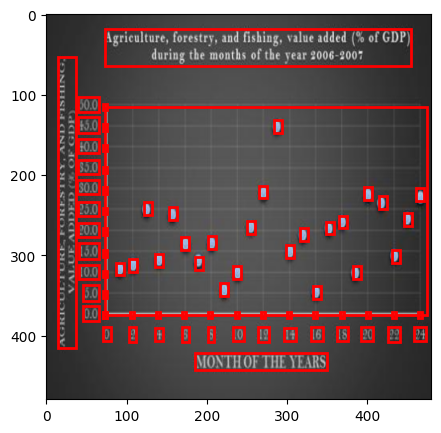

In [ ]:
def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes'].to('cpu')):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()
    
# plotting the image with bboxes. Feel free to change the index
img, target = dataset[25]
plot_img_bbox(img, target)

In [14]:
def get_transform(train):
    if train:
        return A.Compose([
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0) 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

**Model**

In [15]:
def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

In [28]:
train_ids, val_ids = train_test_split(range(unique_image.shape[0]),test_size = 0.2)
val_ids, test_ids = train_test_split(val_ids,test_size = 0.5)

In [29]:
dataset_train = CustDat(df, unique_image, train_ids,get_transform(train=True))
dataset_test = CustDat(df, unique_image, val_ids,get_transform(train=False))
dataset_val = CustDat(df, unique_image, test_ids,get_transform(train=False))

# define training and validation data loaders
data_loader_train = torch.utils.data.DataLoader(
    dataset_train, batch_size=10, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=10, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_val = torch.utils.data.DataLoader(
    dataset_val, batch_size=10, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [18]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [19]:
device

device(type='cuda')

In [20]:
model = get_object_detection_model(NUM_CLASSES + 1)
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)
     

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 110MB/s]


**Training**

In [21]:
model.load_state_dict(torch.load('/content/drive/MyDrive/miniProject/pretrain/weightRCNN.pt'))

<All keys matched successfully>

In [ ]:
num_epochs = 10

# lr_scheduler.step()
for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_val, device=device)

Epoch: [0]  [  0/900]  eta: 2:07:37  lr: 0.000011  loss: 0.4539 (0.4539)  loss_classifier: 0.1057 (0.1057)  loss_box_reg: 0.2523 (0.2523)  loss_objectness: 0.0249 (0.0249)  loss_rpn_box_reg: 0.0710 (0.0710)  time: 8.5088  data: 6.2252  max mem: 8381
Epoch: [0]  [ 10/900]  eta: 0:44:51  lr: 0.000066  loss: 0.4923 (0.5028)  loss_classifier: 0.1149 (0.1162)  loss_box_reg: 0.2695 (0.2794)  loss_objectness: 0.0255 (0.0282)  loss_rpn_box_reg: 0.0754 (0.0790)  time: 3.0243  data: 0.8789  max mem: 8381
Epoch: [0]  [ 20/900]  eta: 0:39:31  lr: 0.000122  loss: 0.4798 (0.4859)  loss_classifier: 0.1123 (0.1129)  loss_box_reg: 0.2691 (0.2698)  loss_objectness: 0.0270 (0.0288)  loss_rpn_box_reg: 0.0717 (0.0744)  time: 2.4047  data: 0.2594  max mem: 8381
Epoch: [0]  [ 30/900]  eta: 0:36:37  lr: 0.000177  loss: 0.4513 (0.4681)  loss_classifier: 0.1023 (0.1087)  loss_box_reg: 0.2493 (0.2609)  loss_objectness: 0.0271 (0.0285)  loss_rpn_box_reg: 0.0641 (0.0700)  time: 2.2515  data: 0.1249  max mem: 8381


In [30]:
evaluate(model, data_loader_val, device=device)

creating index...
index created!
Test:  [  0/113]  eta: 0:20:40  model_time: 0.9491 (0.9491)  evaluator_time: 1.0812 (1.0812)  time: 10.9774  data: 8.9303  max mem: 8381
Test:  [100/113]  eta: 0:00:30  model_time: 0.8683 (0.8923)  evaluator_time: 1.0809 (1.2090)  time: 2.2245  data: 0.0730  max mem: 8381
Test:  [112/113]  eta: 0:00:02  model_time: 0.8541 (0.8842)  evaluator_time: 0.9211 (1.1474)  time: 1.7767  data: 0.0613  max mem: 8381
Test: Total time: 0:04:11 (2.2252 s / it)
Averaged stats: model_time: 0.8541 (0.8842)  evaluator_time: 0.9211 (1.1474)
Accumulating evaluation results...
DONE (t=1.21s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.512
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.766
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.542
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.402
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=me

In [31]:
torch.save(model.state_dict(),'/content/drive/MyDrive/miniProject/pretrain/weightRCNN.pt')

In [ ]:
model.eval()

**Test**

In [ ]:
def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

In [ ]:
img, target = dataset_test[5]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  57
real #boxes:  52


EXPECTED OUTPUT


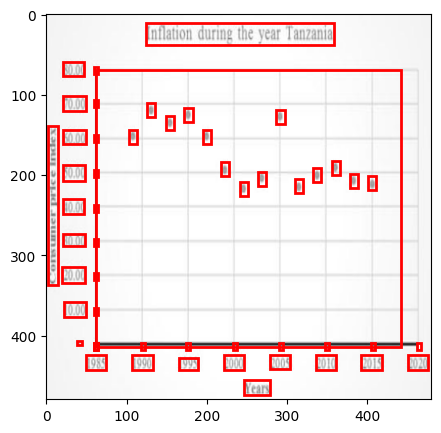

In [ ]:
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img), target)

In [ ]:
target

MODEL OUTPUT


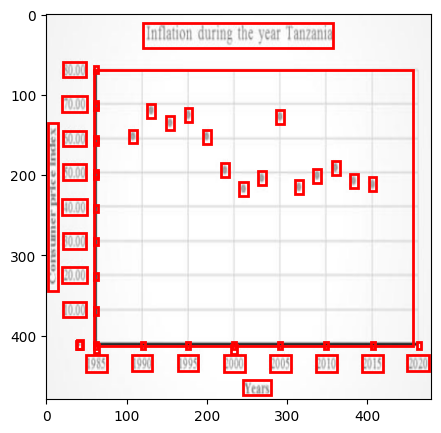

In [ ]:
print('MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), prediction)

NMS APPLIED MODEL OUTPUT


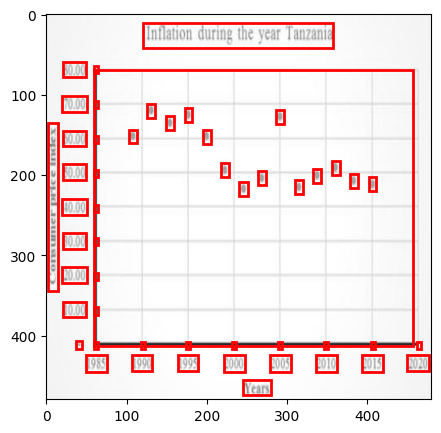

In [ ]:
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), nms_prediction)

In [ ]:
print(len(nms_prediction['boxes']))

51
